# Import all Libraries

In [1]:
import numpy as np
import pandas as pd
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan

# Connect to Elastic Search

In [2]:
# create a client instance of the library
es = Elasticsearch(host='localhost', port=9200)

# Function to fetch the Ids and their Respective Messages

In [3]:
def get_data_from_elastic():
    # query: The elasticsearch query.
    query = {
    
    }
    # Scan function to get all the data. 
    response = scan(client=es,             
               query=query,                                     
               scroll='2m',
               index='*.27',
               raise_on_error=True,
               preserve_order=False,
               clear_scroll=True)

    # Keep response in a list.
    result = list(response)
    print("! ",result)
    ids =[]
    for i in range(len(result)):
        ids.append(result[i]["_id"])
    temp = []
    
    # We need only '_source', which has all the fields required.
    for hit in result:
        
        temp.append(hit['_source'])
    # Create a dataframe.
    df = pd.DataFrame(temp)

    return (ids,df)

In [5]:
data = get_data_from_elastic()
ids = data[0]
df = data[1]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
#Meassage Example
df['message'][1]

'Jan 23 06:57:21 combo sshd(pam_unix)[28729]: authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=202.127.25.130 '

In [6]:
msg_list = list(df['message'])
for msg in msg_list:
    #To replace \220 with another value
    msg.replace('\220','>')

# Text Cleaning

In [7]:
import re
import html

clean_msg_list=[]
for msg in msg_list:
    #Various regular expressions to clean the message data
    #To remove the word combo from the msgs
    msg = re.sub('combo',"",msg)
    #To remove various emailIds
    msg = re.sub(r'^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$',' ',msg)
    #To remove the hyperlinks
    msg = re.sub(r'https?:\/\/.\S+', " ", msg)
    
    #To remove the date and time from the msgs
    #Format = Time(HH:MM:SS)
    msg = re.sub(r'(\d)?\d:\d\d:\d\d','',msg)
    #Format = Date(Int)(MM/DD/YYYY)/(MM-DD-YYYY)/(MM.DD.YYYY)/(MM DD YYYY)
    msg = re.sub(r'(0?[1-9]|1[012])[- /.](0?[1-9]|[12][0-9]|3[01])[- /.](19|20)?[0-9]{2}( )?$','',msg)
    #Format = Date(Int)(DD/MM/YYYY)/(DD-MM-YYYY)/(DD.MM.YYYY)/(DD MM YYYY)
    msg = re.sub(r'(0?[1-9]|[12][0-9]|3[01])[- /.](0?[1-9]|1[012])[- /.](19|20)?[0-9]{2}( )?$','',msg)
    #Format = Date(Int)(YYYY/MM/DD/)/(YYYY-MM-DD)/(YYYY.MM.DD)/(YYYY MM DD)
    msg = re.sub(r'(19|20)?[0-9]{2}[- /.](0?[1-9]|1[012])[- /.](0?[1-9]|[12][0-9]|3[01])( )?$','',msg)
    #Format = Date(Int) MOnth(Str) Year(Int)
    msg = re.sub(r'(\d)?\d( )? \S\S\S( )?','',msg)
    #Format = Month(Str) Date(Int)
    msg = re.sub(r'\S\S\S( )? (\d)?\d( )?','',msg)
    #Format = Day(Str) Month(Str) Date(Int) Year(YYYY)
    msg = re.sub(r'(\S\S\S )?(\S\S\S )?(\S\S\S)?( )? (\d\d\d\d)?$','',msg)
    #Format = MOnth(Str) Date(Int) Year(Int)
    msg = re.sub(r'\S\S\S( )?[- /.](\d)?\d( )?[- /.](\d\d\d\d)?$','',msg)
    #Format = Date(Int) MOnth(Str) Year(Int)
    msg = re.sub(r'(\d)?\d( )?[- /.]\S\S\S( )?[- /.](\d\d\d\d)?$','',msg)
    #Format = Year(Int) Month(Str) Date(Int)
    msg = re.sub(r'\d\d\d\d( )?[- /.]\S\S\S( )?[- /.](\d)?\d( )?$','',msg)
    
    #To remove IP Addresses
    msg = re.sub(r'((?:(?:25[0-5]|2[0-4]\d|((1\d{2})|([1-9]?\d)))\.){3}(?:25[0-5]|2[0-4]\d|((1\d{2})|([1-9]?\d))))','',msg)
    #To remove any substring of #%abc42 type
    msg = re.sub('\%\w+','',msg) 
    msg = re.sub('\S_\S+','',msg)
    #To remove ... special characters from the msgs
    msg = re.sub('\...+','',msg)
    #To remove � from the msgs
    msg = re.sub(r'\S\�+','',msg)
    #To remove punctuation
    msg = re.sub(r'[^\w\s]','',msg)
    #To remove digits
    msg = re.sub(r'[0-9\n]','',msg)
    #To remove leading and trailing whitespace character
    msg = re.sub(r'^\s*|\s*$','',msg)
    #To remove Blank Lines
    msg = re.sub(r'\n\s*\r ','',msg)
    #To remove any html links
    msg= html.unescape(msg)
    clean_msg_list.append(msg)

# Tokenization

In [8]:
#Word tokenization
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize


stop_words = list(set(stopwords.words('english')))
stop_words = stop_words+['logname', 'uid','eth','euid','PCI','node','Privacy','IRQ','ttyNODEVssh', 'ruser','rhostjwhp5','IPv','tables','Microcode', 'Driver','Hash', 'interface','family','httpd','info', 'mice','check','pass','cache','spamd','bytes','syslog','klogd','BIOS','protocol','NET','md','arrays','filesystem','CPU','user', 'cyrus','dev', 'type', 'ext3', 'uses','others','internal', 'service','already','floppy','syslogd','ip_tables','startup','use','NET', 'Registered', 'Revision','CDROM', 'drive','hda']
new_Doc=[]
for msg in clean_msg_list:
    nltk_tokens = nltk.word_tokenize(msg)
    filtered_sentence = []
    for w in nltk_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    new_Doc.append(filtered_sentence)
#print(new_Doc)        

# Stemming

In [9]:
# from nltk.stem.wordnet import WordNetLemmatizer as wl
from nltk.stem import PorterStemmer
# wordnet = wl()
porter = PorterStemmer()

doc =[]
for docs in new_Doc:
    arr =[]
    for word in docs:
        arr.append(porter.stem(word))
#         arr.append(wordnet.lemmatize(word))
    doc.append(arr)


# Re-Formation/DeTokenization

In [10]:
from sacremoses import MosesDetokenizer

parsed_logs=[]
for words in doc:
    if words =="":
        continue
    detokens = MosesDetokenizer().detokenize(words, return_str=True)
    if detokens =="":
        continue
    parsed_logs.append(detokens)

# TFIDF Differentiation


In [138]:
final_logs = list(set(parsed_logs))
len(final_logs)

607

### The purpose of TF - IDF is to highlight words which are frequent  in a document but not cross document

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer

text = final_logs
text1 = parsed_logs

In [157]:
vectorizer = TfidfVectorizer()
vec = TfidfVectorizer()

In [160]:
result = vectorizer.fit_transform(text)
result1 = vec.fit_transform(text1)

In [142]:
lol = [(k, vectorizer.vocabulary_[k]) for k in vectorizer.vocabulary_]

In [269]:
arr = result.toarray()
print(len(arr))
arr1 = result1.toarray()
print(len(arr1))
# idf_df = pd.DataFrame(result.toarray(),columns=vectorizer.get_feature_names())

607
25566


## Applying Histogram-based Outlier Detection (HBOS)

In [283]:
from pyod.models.hbos import HBOS
n_bins = 50
hbos = HBOS(n_bins=n_bins)
hbos.fit(arr1)
HBOS(alpha=0.5, contamination=0.1, n_bins=n_bins, tol=0.5)


HBOS(alpha=0.5, contamination=0.1, n_bins=50, tol=0.5)

In [284]:
test1 = arr1[:1000]
train1 = arr1[1000:]
model = hbos.fit(train1)
y_scores = model.decision_function(test1)*-1

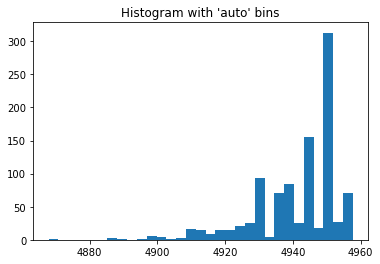

In [285]:
import matplotlib.pyplot as plt
plt.hist(y_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
#plt.margins(-0.4,-0.4)
# plt.xlim((5200, 5220))
# plt.ylim((0, 100))
plt.show()

In [286]:
anomly = []
for i in range(len(y_scores)):
    if y_scores[i]<4920:
        anomly.append(i)
print(len(anomly))
# print(len(y_scores))

76
1000


In [297]:
df_plot = pd.DataFrame()
df_plot['score'] = y_scores
df_plot['cluster'] = np.where(df_plot['score']<4880, 0, 1)
df_plot['cluster'].value_counts()
df_plot.groupby('cluster').mean()

,score
cluster,
0,4867.807088
1,4941.294675


## Isolation Forest

In [264]:
from pyod.models.iforest import IForest

In [272]:
test = arr1[:1000]
train = arr1[1000:]
train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [273]:
forest = IForest(behaviour="new")
forest.fit(train)


IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [274]:
score_pred = forest.decision_function(test)

In [279]:
score_pred = pd.Series(score_pred)
score_pred.head()

0   -0.022551
1   -0.001615
2   -0.001615
3   -0.011126
4   -0.001615
dtype: float64

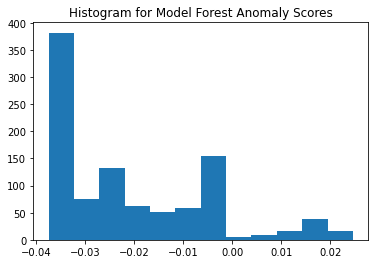

In [298]:
import matplotlib.pyplot as plt
plt.hist(score_pred, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Forest Anomaly Scores")
plt.show()

In [282]:
cluster = pd.DataFrame()
cluster['distance'] = score_pred
cluster['cluster'] = np.where(cluster['distance']<0.00, 0, 1)
cluster['cluster'].value_counts()
cluster.groupby('cluster').mean()

,distance
cluster,
0,-0.024014
1,0.015929


## DB Scan 

In [242]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from sklearn.cluster import DBSCAN
distance_array = pairwise_distances(arr, metric='cosine')

In [243]:
clustering = DBSCAN(eps=0.6, min_samples=3, metric='precomputed').fit(distance_array)

In [244]:
clustering

DBSCAN(eps=0.6, metric='precomputed', min_samples=3)

In [245]:
clustering.labels_

In [246]:
anomlies =[]
for i in range(len(clustering.labels_)):
    if clustering.labels_[i]==-1:
        anomlies.append(i)
print(len(anomlies))

217


In [247]:
val = {
    
    "labels" : list(clustering.labels_),
    "Logs ": final_logs
}
db = pd.DataFrame(val)

In [225]:
db

,labels,Logs
0,0,sshd succeed
1,0,smartd smartd ver
2,2,kernel extf write access enabl recoveri
3,1,ftpd connect f
4,-1,sysctl kernel
...,...,...
602,-1,kernel htor wkib cach ch udma
603,2,kernel selinux initi ram ext xattr
604,17,kernel acpi interpret disabl
605,22,hcid hci daemon


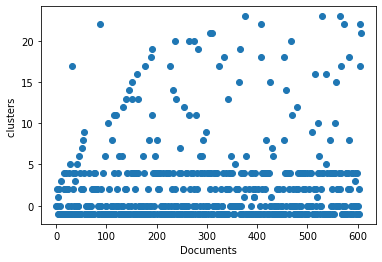

In [248]:
import matplotlib.pyplot as plt
plt.scatter([i for i in range(607)],clustering.labels_)
plt.xlabel('Documents')
plt.ylabel('clusters ')
plt.show()

In [249]:
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler

In [250]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(arr)

In [251]:
mds = MDS(2)
X_2d = mds.fit_transform(X_scaled)

In [252]:
X_2d
x =[]
y =[]
for arr in X_2d:
    x.append(arr[0])
    y.append(arr[1])


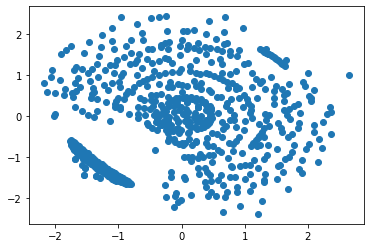

In [253]:
plt.scatter(x,y)
plt.show()

In [254]:
import seaborn

In [255]:
df_plot = pd.DataFrame( {'x_axis': x,
     'y_axis': y,
     'cluster': clustering.labels_
    })

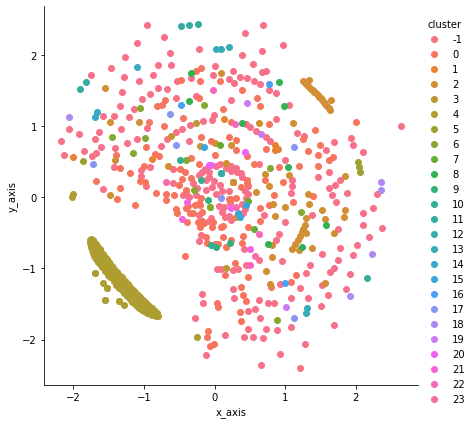

In [256]:
seaborn.FacetGrid(df_plot, hue ="cluster", height = 6).map(
plt.scatter, 'x_axis', 'y_axis').add_legend()

plt.show()

## KMeans Clustering

In [18]:
from sklearn.cluster import KMeans
number_of_clusters=2
km = KMeans(n_clusters=number_of_clusters)

In [19]:
km.fit(result)

KMeans(n_clusters=2)

In [20]:
km.fit

<bound method KMeans.fit of KMeans(n_clusters=2)>

In [21]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: ftpd connect sshdpa failur authent uiddnodevssh rhost kernel unknown session
Cluster 1: out memori kill proctpd kernel procthon procndmail hub htt htor


C:\Users\akesar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [42]:
results = pd.DataFrame()
results['text'] = text
results['category'] = km.labels_
# results

In [46]:
arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 3 categories

In [23]:
from sklearn.cluster import KMeans

number_of_clusters=3
km = KMeans(n_clusters=number_of_clusters)
# Normally people fit the matrix
km.fit(result)
km.fit

<bound method KMeans.fit of KMeans(n_clusters=3)>

In [43]:
results = pd.DataFrame({
    'text': text,
    'category': km.labels_
})
# results

In [25]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, '   '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: out memori kill proctpd kernel procthon procndmail hub htt htor
Cluster 1: sshdpa failur authent uiddnodevssh rhost kernel unknown session supa rhostrroot
Cluster 2: ftpd connect fst fm getpeernam endpoint transport fil zone host


C:\Users\akesar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## WCSS method

In [26]:
wcss_list= [] 
for i in range(1, 11):  
    kmeans = KMeans(n_clusters=i)  
    kmeans.fit(result)  
    wcss_list.append(kmeans.inertia_)


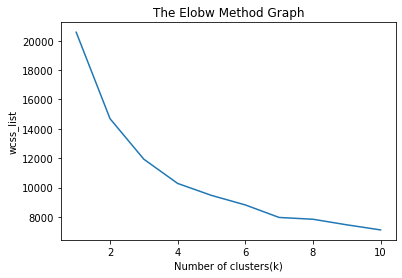

In [32]:
import matplotlib.pyplot as mtp
mtp.plot(range(1, 11), wcss_list)  
mtp.title('The Elbow Method Graph')  
mtp.xlabel('Number of clusters(k)')  
mtp.ylabel('wcss_list')  
mtp.show()  

In [30]:
from sklearn.cluster import KMeans

number_of_clusters=3
km = KMeans(n_clusters=number_of_clusters)
# Normally people fit the matrix
km.fit(result)

KMeans(n_clusters=3)

In [33]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, '  '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: sshdpa  failur  authent  uiddnodevssh  rhost  kernel  unknown  session  supa  rhostrroot
Cluster 1: out  memori  kill  proctpd  kernel  procthon  procndmail  hub  htt  htor
Cluster 2: ftpd  connect  fst  fm  getpeernam  endpoint  transport  fil  zone  host


In [51]:
type(order_centroids)

numpy.ndarray

In [52]:
order_centroids

array([[726, 239,  47, ..., 434, 812, 517],
       [371, 470, 418, ..., 561, 560,   0],
       [268, 133, 851, ..., 563, 562,   0]], dtype=int64)

In [56]:
km.cluster_centers_.argsort()[:,::-1]

array([[726, 239,  47, ..., 434, 812, 517],
       [371, 470, 418, ..., 561, 560,   0],
       [268, 133, 851, ..., 563, 562,   0]], dtype=int64)